<a href="https://colab.research.google.com/github/umamahabbasi24/ML-internship-second-phase-notebooks/blob/main/Multimodal_Housing_Price_Prediction_Images_Tabular_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📓 Multimodal ML – Housing Price Prediction Using **Images + Tabular Data**

A complete, ready-to-run Google Colab notebook that builds a **multimodal regression model** combining a **CNN** for images with an **MLP** for tabular features to predict house prices.


## 🎯 Objectives
- Extract image features using a **Convolutional Neural Network (CNN)**
- Combine extracted **image features** with **tabular features**
- Train an end-to-end **multimodal regression** model
- Evaluate with **MAE** and **RMSE**


## 🔧 Setup and Environment

In [ ]:
# If you're on Colab, you can run this cell to ensure dependencies are present.
# It is safe to re-run; if everything is already installed, it will be quick.
!pip -q install -U tensorflow pandas scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but yo

## 📦 Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model, Input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

np.random.seed(42)
tf.random.set_seed(42)
print('TensorFlow:', tf.__version__)


TensorFlow: 2.20.0


## ⚙️ Hardware Check

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name:
    print('GPU detected:', device_name)
else:
    print('No GPU detected. CPU runtime will work, but training may be slower.')


No GPU detected. CPU runtime will work, but training may be slower.


## 🧰 Data Preparation
For a self-contained demo, we generate a **synthetic dataset** that roughly resembles housing data. You can later replace this with your real images and tabular CSV.

In [ ]:
# --- Generate synthetic tabular data ---
num_samples = 600
tabular_df = pd.DataFrame({
    'size_sqft': np.random.randint(500, 4000, num_samples),
    'num_rooms': np.random.randint(1, 8, num_samples),
    'house_age': np.random.randint(1, 50, num_samples),
    'location_score': np.random.randint(1, 10, num_samples)
})

# Price signal + noise
prices = (
    tabular_df['size_sqft'] * 220
    + tabular_df['num_rooms'] * 6000
    - tabular_df['house_age'] * 1200
    + tabular_df['location_score'] * 12000
    + np.random.randint(-30000, 30000, num_samples)
)
tabular_df['price'] = prices.astype('float32')
tabular_df.head()


,size_sqft,num_rooms,house_age,location_score,price
0,3674,7,15,1,855027.0
1,1360,2,11,5,363196.0
2,1794,2,8,9,520193.0
3,1630,3,26,1,367594.0
4,1595,2,45,9,395433.0


### 🖼️ Image Data
We create random 64×64 RGB images for this demo. Replace `image_data` with real house images for your project.

In [ ]:
img_h, img_w = 64, 64
image_data = np.random.rand(num_samples, img_h, img_w, 3).astype('float32')
image_data = image_data / 255.0
image_data.shape


(600, 64, 64, 3)

## 🔀 Train/Test Split & Scaling

In [ ]:
X_tab = tabular_df.drop(columns=['price']).values.astype('float32')
y = tabular_df['price'].values.astype('float32')

X_tab_train, X_tab_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
    X_tab, image_data, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_tab_train = scaler.fit_transform(X_tab_train)
X_tab_test = scaler.transform(X_tab_test)

X_tab_train.shape, X_img_train.shape, y_train.shape


((480, 4), (480, 64, 64, 3), (480,))

## 🧠 Multimodal Model Architecture
We build two branches:
1. **CNN** for image features
2. **MLP** for tabular features
Then we **concatenate** (fuse) both representations and predict the price.

In [ ]:
# --- CNN branch ---
cnn_input = Input(shape=(img_h, img_w, 3), name='image_input')
x = layers.Conv2D(32, 3, activation='relu', padding='same')(cnn_input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
cnn_out = layers.Dropout(0.3)(x)

# --- MLP branch ---
tab_input = Input(shape=(X_tab_train.shape[1],), name='tabular_input')
y_tab = layers.Dense(64, activation='relu')(tab_input)
y_tab = layers.Dense(32, activation='relu')(y_tab)
tab_out = layers.Dropout(0.2)(y_tab)

# --- Fusion ---
combined = layers.Concatenate()([cnn_out, tab_out])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(32, activation='relu')(z)
output = layers.Dense(1, name='price')(z)

model = Model(inputs=[cnn_input, tab_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        320 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price (Dense)       │ (None, 1)         │         33 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,577 (486.63 KB)

 Trainable params: 124,577 (486.63 KB)

 Non-trainable params: 0 (0.00 B)

## 🚀 Training

In [ ]:
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_data=([X_img_test, X_tab_test], y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 628ms/step - loss: 368918626304.0000 - mae: 564772.5000 - val_loss: 365919338496.0000 - val_mae: 561344.0000
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - loss: 368915120128.0000 - mae: 564769.3750 - val_loss: 365892829184.0000 - val_mae: 561320.3125
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - loss: 368845619200.0000 - mae: 564707.5625 - val_loss: 365494370304.0000 - val_mae: 560965.3125
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step - loss: 368006266880.0000 - mae: 563960.2500 - val_loss: 361786015744.0000 - val_mae: 557650.3750
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - loss: 361299902464.0000 - mae: 557949.3750 - val_loss: 338379669504.0000 - val_mae: 536253.8750
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 324156522496.0000 - mae: 523007.1250 - val_loss: 238024212480.0000 - val_mae: 432683.5312
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 314ms/step - loss: 192657391616.0000 - mae: 378146.6562 - 

## 📊 Learning Curves

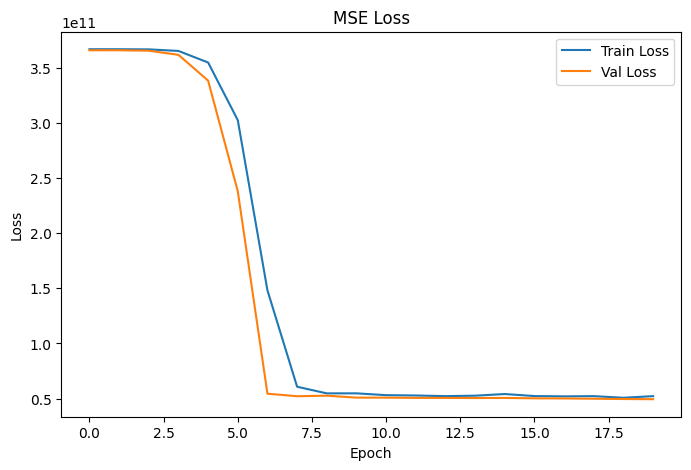

In [ ]:
# Plot training and validation MSE loss (single chart, no custom colors)
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


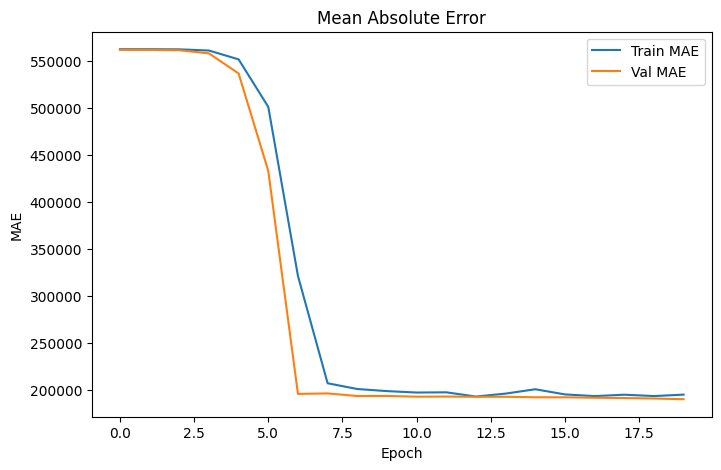

In [ ]:
# Plot training and validation MAE (single chart, no custom colors)
plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


## ✅ Evaluation (MAE & RMSE)

In [ ]:
y_pred = model.predict([X_img_test, X_tab_test]).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
MAE: 189944.39
RMSE: 222350.44


## 📌 Using Your Real Dataset
Replace the synthetic data generation with your own:
1. **Tabular CSV**: Load with `pd.read_csv('your.csv')` and separate features/target.
2. **Images**: Load and preprocess to `(H, W, 3)` arrays (e.g., with `tf.keras.utils.load_img` / `img_to_array`).
3. Keep the split + scaling, and reuse the model/fusion/training cells unchanged